In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import waveresponse as wr
import warnings
warnings.filterwarnings("ignore") 

df = pd.read_csv('resources/diffraction_data.csv')
df

,omega,radiating_dof,influenced_dof,wave_direction,added_mass,radiation_damping,diffraction_force_real,diffraction_force_imag,Froude_Krylov_force_real,Froude_Krylov_force_imag,...,RAO_imag,g,rho,body_name,water_depth,forward_speed,freq,period,wavenumber,wavelength
0,0.1,Surge,Surge,0.261799,7.446759e+10,1.595318e+10,-1.790022e+09,2.723478e+09,-1.727951e+09,-8.232714e+08,...,-1.743012e-01,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
1,0.1,Surge,Surge,0.523599,7.446759e+10,1.595318e+10,-1.941504e+09,1.602996e+09,-1.841188e+09,-1.749525e+09,...,-3.485170e-02,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
2,0.1,Surge,Surge,1.570796,7.446759e+10,1.595318e+10,9.511897e+08,1.625561e+09,3.894640e+08,-6.353220e+07,...,-4.999025e-04,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
3,0.1,Surge,Surge,3.141593,7.446759e+10,1.595318e+10,3.795288e+09,-1.318699e+09,-1.646089e+09,4.896295e+08,...,1.140041e+00,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
4,0.1,Surge,Sway,0.261799,7.576095e+08,-2.608337e+08,1.470351e+08,7.247697e+08,-4.601658e+08,-2.161325e+08,...,-1.743012e-01,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,5.0,Yaw,Pitch,3.141593,3.615509e+15,3.261742e+09,4.233314e+12,2.782396e+11,-4.231877e+12,-2.777575e+11,...,-2.718630e-11,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522
1580,5.0,Yaw,Yaw,0.261799,7.915202e+16,4.671514e+09,-1.603842e+07,-2.189251e+07,-1.413336e-04,-3.751700e-05,...,2.961695e-12,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522
1581,5.0,Yaw,Yaw,0.523599,7.915202e+16,4.671514e+09,7.513616e+07,8.687851e+05,-1.059101e-04,3.716814e-04,...,2.083688e-12,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522
1582,5.0,Yaw,Yaw,1.570796,7.915202e+16,4.671514e+09,-1.295069e+07,1.081454e+08,-3.066250e-05,-1.384699e-04,...,-1.339273e-11,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522


In [38]:
df_mean = (
    df.groupby(["omega", "radiating_dof"], as_index=False)[["RAO_real", "RAO_imag"]]
      .mean()
)
df_mean

,omega,radiating_dof,RAO_real,RAO_imag
0,0.1,Heave,5.575507e-01,-9.589102e-01
1,0.1,Pitch,-1.801775e-04,3.251737e-04
2,0.1,Roll,5.071933e-05,2.909149e-04
3,0.1,Surge,-6.615179e-02,2.325970e-01
4,0.1,Sway,3.437752e-02,1.227908e-01
...,...,...,...,...
61,5.0,Pitch,-9.674667e-12,2.807846e-11
62,5.0,Roll,4.715639e-11,-6.882062e-11
63,5.0,Surge,-3.921833e-09,-6.121352e-09
64,5.0,Sway,-7.121726e-10,2.900553e-09


In [39]:
# creative wave using jonswap spectrum
# hs - wave height
# tp - peak period
# dirp is peak direction
def create_wave(freq, dirs, hs, tp, dirp):
    _, vals = wr.JONSWAP(freq, freq_hz=True)(hs, tp)
    spread_fun = wr.CosineFullSpreading(s=2, degrees=True)

    wave = wr.WaveSpectrum.from_spectrum1d(
        freq,
        dirs,
        vals,
        spread_fun,
        dirp,
        freq_hz=False,
        degrees=True,
        clockwise=False,
        waves_coming_from=False,
    )
    return wave

In [40]:
def custom_RAO(dof):
    sub = (
        df_mean[df_mean["radiating_dof"] == dof]
        .sort_values("omega")
    )
    omega = sub["omega"].to_numpy()      
    rao_real = sub["RAO_real"].to_numpy()    
    rao_imag = sub["RAO_imag"].to_numpy() 

    dirs = np.array([0.0])                  
    rao_complex = rao_real + 1j * rao_imag
    rao_vals = rao_complex[:, None] 
    
    rao = wr.RAO(
        omega,
        dirs,
        rao_vals,
        freq_hz=False,       
        degrees=True,       
        clockwise=False,
        waves_coming_from=True,
    )
    return rao

In [41]:
def rao_response_plots_freq(ax, dofs, wave, heading):
    rao_response = []
    for i, dof in enumerate(dofs):
        rao = custom_RAO(dof)
        response = wr.calculate_response(rao, wave, heading, heading_degrees=True)
        _, response_spectrum = response.spectrum1d(axis=1)
 
        x = np.linspace(0, 5, response_spectrum.size)
        ax[i].plot(x, response_spectrum)
        ax[i].set_title(f'{dof}')
        ax[i].set_ylabel('RAO Response')
        ax[i].set_xlabel('Omega (rad/s)')
        rao_response.append(response_spectrum)
    return ax, rao_response

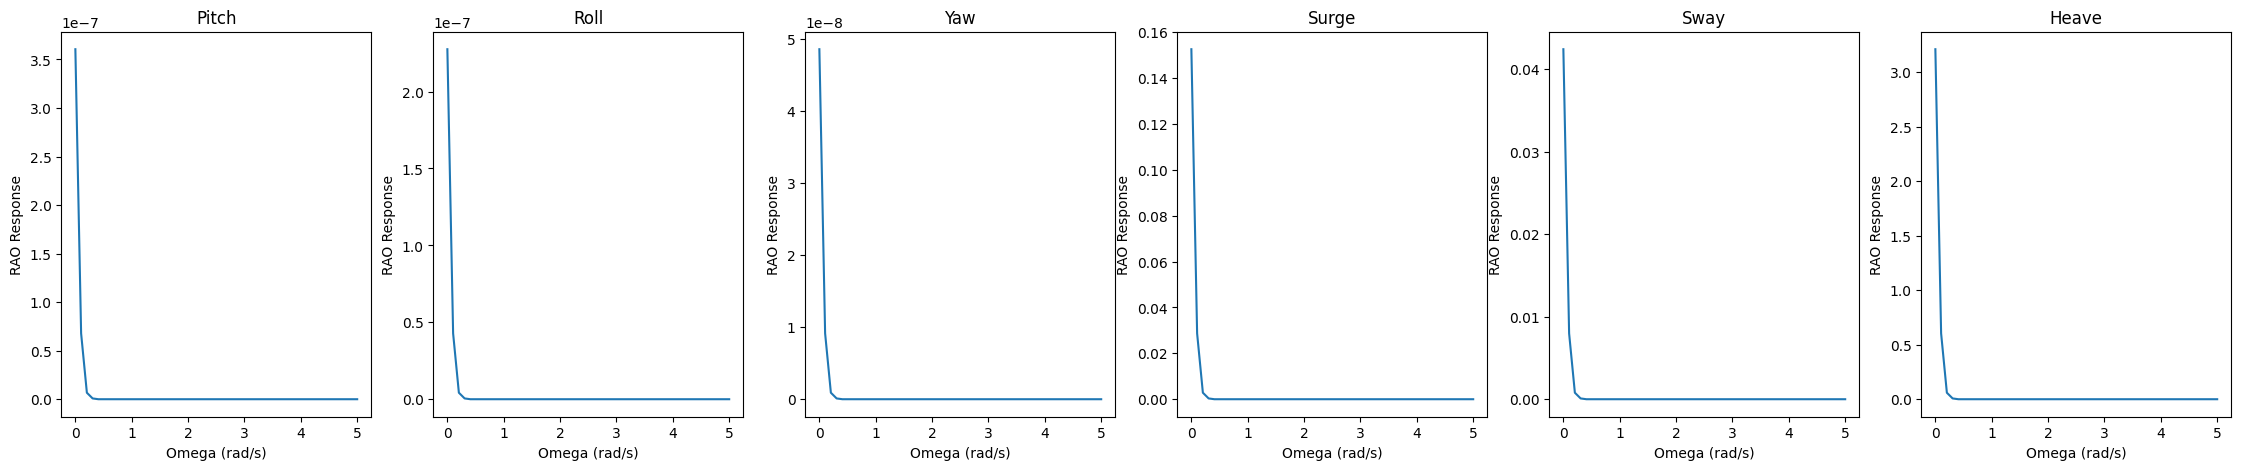

In [42]:
# create_wave() params
freq = np.linspace(0.1, 5, 50)
dirs = np.linspace(0.0, 360.0, endpoint=False)
hs = 2.5 
tp = 8.53
gamma = 3.3  

# rao_response_plot() params
heading = 30
dofs = ["Pitch", "Roll", "Yaw", "Surge", "Sway", "Heave"]
fig, ax = plt.subplots(1, 6, figsize=(28, 5))

wave = create_wave(freq, dirs, hs, tp, heading)
ax, response_spectrum = rao_response_plots_freq(ax, dofs, wave, heading)
plt.show()

In [43]:
csv = "\n".join(
    ",".join(map(str, row))
    for row in zip(*response_spectrum)
)

with open("rao_response_spectrum.csv", "w", newline="") as f:
    f.write(",".join(dofs) + "\n")
    f.write(csv)

In [44]:
df = pd.read_csv('rao_response_spectrum.csv')
df

,Pitch,Roll,Yaw,Surge,Sway,Heave
0,3.605750e-07,2.275190e-07,4.858865e-08,1.525703e-01,4.242151e-02,3.210096e+00
1,6.779517e-08,4.277296e-08,9.137992e-09,2.869092e-02,7.973837e-03,6.033806e-01
2,6.704244e-09,4.228803e-09,9.041223e-10,2.838169e-03,7.880879e-04,5.963250e-02
3,8.129958e-10,5.124455e-10,1.098094e-10,3.445111e-04,9.540762e-05,7.218456e-03
4,9.960972e-13,3.885919e-13,2.465005e-13,6.445649e-07,1.131915e-08,3.405905e-07
5,3.208823e-13,1.251878e-13,7.940573e-14,2.076348e-07,3.646273e-09,1.097176e-07
6,1.114436e-13,4.348220e-14,2.757686e-14,7.210940e-08,1.266323e-09,3.810534e-08
7,3.812564e-14,1.487831e-14,9.433516e-15,2.466711e-08,4.331896e-10,1.303609e-08
8,1.058344e-14,4.132412e-15,2.618087e-15,6.845763e-09,1.202272e-10,3.618732e-09
9,3.117469e-18,3.917132e-18,6.463739e-20,3.895345e-14,7.606979e-15,1.057882e-12
